In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import matplotlib.ticker as plticker
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from cpsplines.fittings.grid_cpsplines import GridCPsplines
from cpsplines.graphics.plot_curves import CurvesDisplay
from cpsplines.graphics.plot_surfaces import SurfacesDisplay
from cpsplines.utils.clean_data_covid import (displaced_forecast_covid,
                                             filter_covid_df,
                                             pivot_covid_df,
                                             agg_covid_by_age,
                                             get_days_from_covid_df)
from cpsplines.utils.rearrange_data import grid_to_scatter

*Example 1*. Smoothing of the normalized number of infections in Comunitat Valenciana
(constituted by the Spanish regions of Alacant, València and Castelló) from the
first event date to 4th October 2021. 

[Solve the problem with smoothing parameters (0.02004481621380845,): ] Elapsed time (s): 0.060423


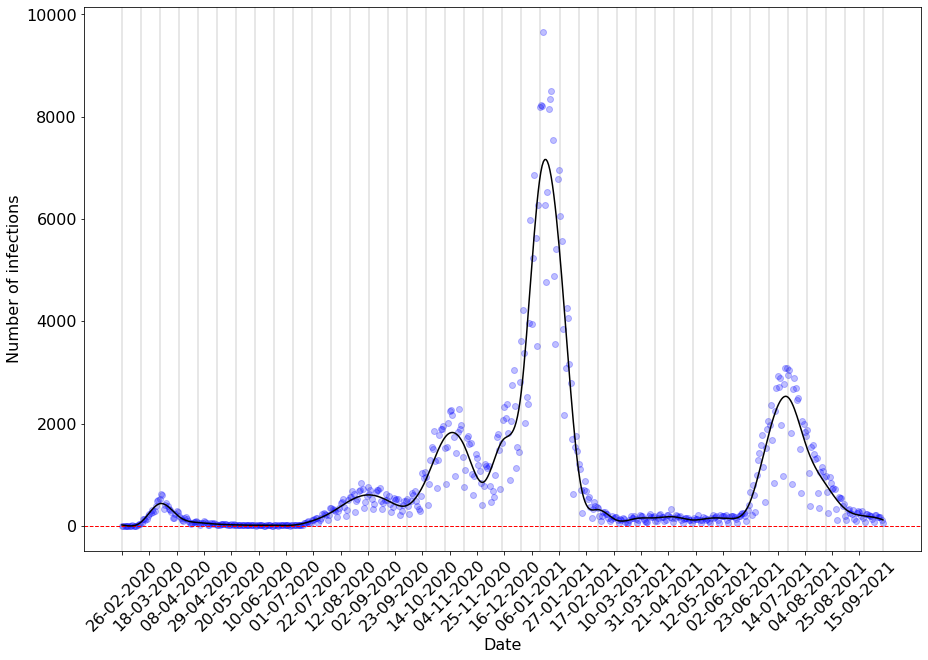

In [3]:
df = filter_covid_df(
    response_var="num_casos",
    min_date=None,
    max_date=pd.Timestamp(2021,10,4), 
    gender=None,
    region=("A", "CS", "V"),
).pipe(agg_covid_by_age, response_var="num_casos")
dates = df.index
days = get_days_from_covid_df(df=df)
num_casos = df.values.T[0]
data = pd.DataFrame({"days": days, "num_casos": num_casos})

example1d = GridCPsplines(deg=(3,),
                          ord_d=(2,),
                          n_int=(40,),
                          sp_args={"options": {"ftol": 1e-12}},
                          int_constraints={0: {0: {"+": 0}}})
example1d.fit(data=data, y_col="num_casos", y_range=(0,1))
# Plot the results
plot1d =  CurvesDisplay.from_estimator(example1d,
                                       X=data["days"],
                                       y=data["num_casos"],
                                       knot_positions=True, 
                                       constant_constraints=True,
                                       col_pt="b",
                                       **{"c": "k"})
_ = plot1d.ax_.set_xticks(days[::21])
_ = plot1d.ax_.set_xticklabels(dates[: len(days) : 21].strftime("%d-%m-%Y").values, rotation=45)
_ = plot1d.ax_.set_ylabel("Number of infections", fontsize=16)
_ = plot1d.ax_.set_xlabel("Date", fontsize=16)
_ = plot1d.ax_.tick_params(axis="both", which="major", labelsize=16)

*Example 2*. Smoothing of the normalized number of infections by age group for
males in Alacant from the first event date to 4th October 2021. 

[Solve the problem with smoothing parameters (0.00105838086360363, 4.433241861941119): ] Elapsed time (s): 1.057497


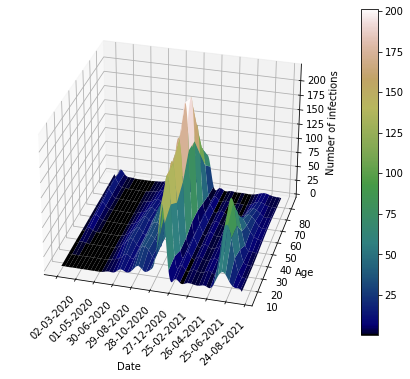

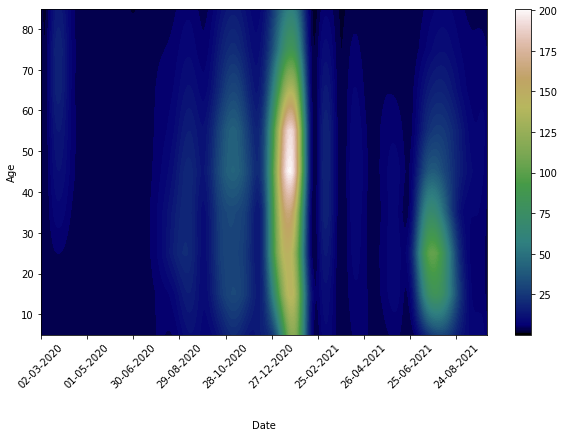

In [4]:
df = filter_covid_df(
    response_var="num_casos",
    min_date=None,
    max_date=pd.Timestamp(2021,10,4),
    gender=("H",),
    region=("A",),
).pipe(pivot_covid_df, response_var="num_casos")

dates = df.index
days = get_days_from_covid_df(df=df)
ages = np.array([code * 10 + 5 for code in df.columns.codes])
num_casos = df.values
data = grid_to_scatter(x=[days, ages], y=num_casos, y_col="num_casos")

example2d = GridCPsplines(deg=(3,3),
                          ord_d=(2,2),
                          n_int=(30,20),
                          sp_args={"options": {"ftol": 1e-12}},
                          int_constraints={0: {0: {"+": 0}}, 1: {0: {"+": 0}}})
example2d.fit(data=data, y_col="num_casos", y_range=(0,1))

plot2d = SurfacesDisplay.from_estimator(example2d, 
                                   orientation=(30, 285), 
                                   figsize=(10, 6), 
                                   **{"cmap": "gist_earth"}
                                   )
for ax in (plot2d.ax_, plot2d.ax_contour_):
    _ = ax.set_xticks(days)
    _ = ax.set_xticklabels(dates.strftime("%d-%m-%Y"), rotation=45)
    _ = ax.xaxis.set_major_locator(plticker.MultipleLocator(base=60.0))
    _ = ax.set_xlabel("Date", labelpad=30)
    _ = ax.set_ylabel("Age")
_ = plot2d.ax_.set_zlabel("Number of infections")

*Example 3*. Smoothing of the number of infections in the Spanish region of Aragón and forecasting under different scenarios. The data is gathered from 6th February 2020 (first infection when accessed the data on September 2020) to 6th July. The growth rates of the first wave from day 7 (strong evidence that the number of cases is growing) to day 5 after the peak (strong evidence the number of cases is decreasing) are considered. Then, four models are run:
- Non-negativity both in the fitting and the forecasting region (blue).
- Non-negativity both in the fitting and the forecasting region (brown).
  Derivatives on the first wave are imposed on the second wave with the same
  frequency. 
- Non-negativity both in the fitting and the forecasting region (violet).
  Double of the derivatives on the first wave are imposed on the second wave
  with 1-day lag.
- Non-negativity both in the fitting and the forecasting region (green).
  1.5 of the derivatives on the first wave are imposed on the second wave with
  0.8-day lag.

[Solve the problem with smoothing parameters (0.01,): ] Elapsed time (s): 0.155614
[Solve the problem with smoothing parameters (0.01,): ] Elapsed time (s): 0.063411
[Solve the problem with smoothing parameters (0.01,): ] Elapsed time (s): 0.143740
[Solve the problem with smoothing parameters (0.01,): ] Elapsed time (s): 0.152922


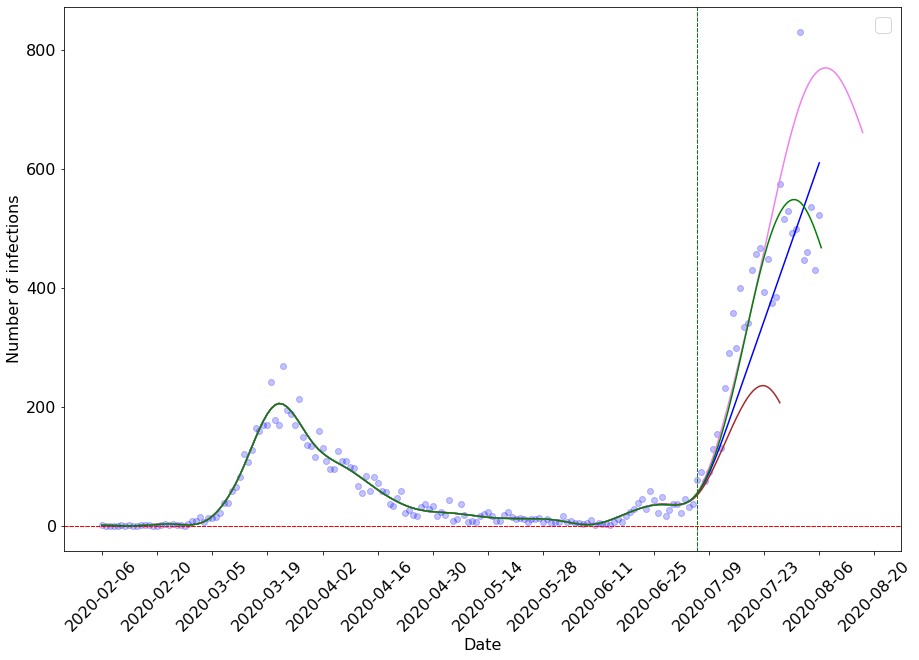

In [5]:
data_aragon = pd.read_csv(Path("../data/covid_aragon_1D.csv"))
dates = pd.to_datetime(data_aragon["fecha"]).dt.date
x_sam = data_aragon.index.values[:183]
y_sam = data_aragon["num_casos"].values[: len(x_sam)]
data = pd.DataFrame({"days": x_sam, "num_casos": y_sam})

example_pt = GridCPsplines(deg=(3,),
                              ord_d=(2,),
                              n_int=(17,),
                              x_range={0: (max(x_sam), )},
                              sp_method="grid_search",
                              sp_args={"grid": ((0.01,),)},
                              int_constraints={0: {0: {"+": 0}}})
example_pt.fit(data=data.iloc[:152, :], y_col="num_casos")

deriv_curve = np.matmul(
    example_pt.bspline_bases[0].bspline_basis.derivative(nu=1)(example_pt.bspline_bases[0].xsample),
    example_pt.sol,
)


factors_dict = {"lag": (1, 2, 1.5), "factor_deriv": (1, 2, 1.8)}

curves = [example_pt]

for disp, deriv in zip(factors_dict["lag"], factors_dict["factor_deriv"]):
    disp = displaced_forecast_covid(
        xmax=151,
        lag=disp,
        factor_deriv=deriv,
        deriv=deriv_curve[30:51],
    )
    example_pt2 = GridCPsplines(deg=(3,),
                                  ord_d=(2,),
                                  n_int=(17,),
                                  x_range={0: (disp["x_last"], )},
                                  sp_method="grid_search",
                                  sp_args={"grid": ((0.01,),)},
                                  int_constraints={0: {0: {"+": 0}}},
                                  pt_constraints={(1,): {"equalsTo": pd.DataFrame({"days": disp["x_pred"],
                                                                                  "num_casos": disp["deriv_pred"],
                                                                                  "tol": 2})}})
    example_pt2.fit(data=data.iloc[:152, :], y_col="num_casos")
    curves.append(example_pt2)

label_legend = ["disp: NA, deriv: NA"] + [
    f"disp: {disp}, deriv: {deriv}"
    for disp, deriv in zip(factors_dict["lag"], factors_dict["factor_deriv"])
]
ax = plt.gca()
for estimator, c in zip(curves, ("b", "brown", "violet", "g")):
    _ =  CurvesDisplay.from_estimator(estimator,
                                      X=data["days"].iloc[:152],
                                      y=data["num_casos"].iloc[:152],
                                      constant_constraints=True,
                                      col_pt="b",
                                      ax=ax,
                                      alpha=0.0625,
                                      **{"c": c})
_ = ax.set_xticks(dates.index[:200:14])
_ = ax.set_xticklabels(dates[:200:14].values, rotation=45)
_ = ax.set_ylabel("Number of infections", fontsize=16)
_ = ax.set_xlabel("Date", fontsize=16)
_ = ax.legend(
    ax.get_legend_handles_labels()[0],
    label_legend,
    prop={"size": 20},
)
_ = ax.tick_params(axis='both', which='major', labelsize=16)
_ = ax.scatter(data["days"].iloc[152:], data["num_casos"].iloc[152:], c="b", alpha=0.25)